<a href="https://colab.research.google.com/github/talw98/Classification-of-MRI-Brain-Scans-of-Alzheimer-s-Patients-using-Convolutional-Neural-Networks/blob/main/Cnn_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using [Alzheimer's Disease Dataset](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images), a Deep Learning model (Convulationl Neural Network) has been constructed which will classify MRI Brain Scans of Alzheimer's patients into 4 classes:


1.   Mild Demented

2.   Moderate Demented

3.   Non Demented

4.   Very Mild Demented




In [ ]:
from google.colab import files
files.upload()                  # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karolos","key":"84c1be7d8dd60b8773d60b9c5eaa9da3"}'}

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           6482        192  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1160         30  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4307        100  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [ ]:
!kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images -p /content/sample_data/ --unzip



100% 34.0M/34.1M [00:02<00:00, 24.5MB/s]
100% 34.1M/34.1M [00:02<00:00, 14.4MB/s]


Let's have a look at the data

In [ ]:
!ls "/content/sample_data/Alzheimer_s Dataset/"{test,train}

'/content/sample_data/Alzheimer_s Dataset/test':
MildDemented  ModerateDemented	NonDemented  VeryMildDemented

'/content/sample_data/Alzheimer_s Dataset/train':
MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [ ]:
!ls "/content/sample_data/Alzheimer_s Dataset/"{test,train}/MildDemented/

'/content/sample_data/Alzheimer_s Dataset/test/MildDemented/':
'26 (19).jpg'  '27 (8).jpg'   '29 (15).jpg'  '30 (23).jpg'  '31 (4).jpg'
'26 (20).jpg'  '27 (9).jpg'   '29 (16).jpg'  '30 (24).jpg'  '31 (5).jpg'
'26 (21).jpg'   27.jpg	      '29 (17).jpg'  '30 (25).jpg'  '31 (6).jpg'
'26 (22).jpg'  '28 (10).jpg'  '29 (18).jpg'  '30 (26).jpg'  '31 (7).jpg'
'26 (23).jpg'  '28 (11).jpg'  '29 (19).jpg'  '30 (27).jpg'  '31 (8).jpg'
'26 (24).jpg'  '28 (12).jpg'  '29 (20).jpg'  '30 (28).jpg'  '31 (9).jpg'
'26 (25).jpg'  '28 (13).jpg'  '29 (21).jpg'  '30 (2).jpg'    31.jpg
'26 (26).jpg'  '28 (14).jpg'  '29 (22).jpg'  '30 (3).jpg'   '32 (10).jpg'
'26 (27).jpg'  '28 (15).jpg'  '29 (23).jpg'  '30 (4).jpg'   '32 (11).jpg'
'26 (28).jpg'  '28 (16).jpg'  '29 (24).jpg'  '30 (5).jpg'   '32 (12).jpg'
 26.jpg        '28 (17).jpg'  '29 (25).jpg'  '30 (6).jpg'   '32 (13).jpg'
'27 (10).jpg'  '28 (18).jpg'  '29 (26).jpg'  '30 (7).jpg'   '32 (14).jpg'
'27 (11).jpg'  '28 (19).jpg'  '29 (27).jpg'  '30 (8).jpg'   '3

In [ ]:
!for d in "/content/sample_data/Alzheimer_s Dataset/"{test,train}/* ; do echo "${d/.*Dataset\//}" $(ls "${d}" | wc -l ) ; done

/content/sample_data/Alzheimer_s Dataset/test/MildDemented 179
/content/sample_data/Alzheimer_s Dataset/test/ModerateDemented 12
/content/sample_data/Alzheimer_s Dataset/test/NonDemented 640
/content/sample_data/Alzheimer_s Dataset/test/VeryMildDemented 448
/content/sample_data/Alzheimer_s Dataset/train/MildDemented 717
/content/sample_data/Alzheimer_s Dataset/train/ModerateDemented 52
/content/sample_data/Alzheimer_s Dataset/train/NonDemented 2560
/content/sample_data/Alzheimer_s Dataset/train/VeryMildDemented 1792


(208, 176, 3)


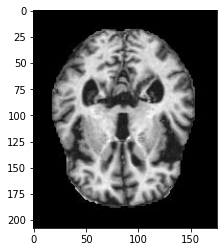

In [ ]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("/content/sample_data/Alzheimer_s Dataset/train/MildDemented/mildDem1.jpg")[:, :, ::-1]
plt.imshow(img)

print(img.shape)


It seems like our images are `208x176` and have 3 'values' of depth.

Let us import them using Tensorflow's built-in capabilities

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

The next snippet is meant to understand what runtime we're running on. For TPU, one needs to run some additional code, but this is ready to go for GPU.

To use a GPU, go to `Runtime` > `Change runtime type` and select GPU.

In [ ]:
# Detect hardware
try:
  # TPU detection
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  # default strategy that works on CPU and single GPU
  strategy = tf.distribute.get_strategy()
  print('Running on single GPU ', gpus[0].name)
else:
  # default strategy that works on CPU and single GPU
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


Let's bring our data in using [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = [176, 208]
SEED = 1

trainDataLoc = "/content/sample_data/Alzheimer_s Dataset/train"

# Creating the training dataset (keeping 20% for validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainDataLoc,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Creating the validation dataset (note: important to keep the same seed)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainDataLoc,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = len(train_ds.class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Let's ahve a look at some more of the imagesin our dataset:

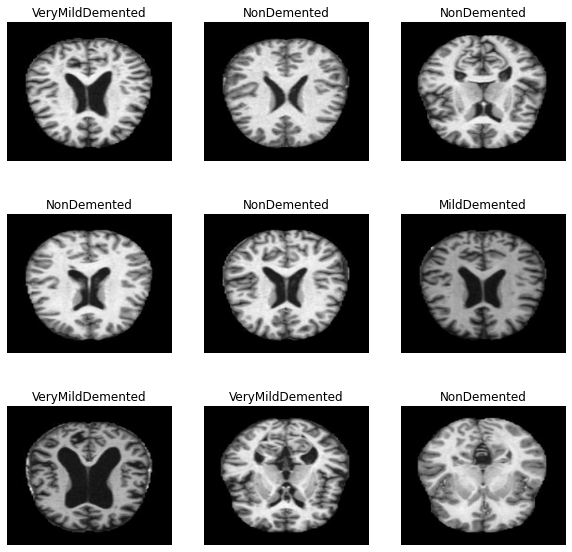

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Because we use categorical non-continuous data, let's use a one-hot encoding.

In [ ]:
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)

Before we proceed, let's try to find out how many images of each kind we have.

In [ ]:
NUM_IMAGES = []
import os
for label in class_names:
    dir_name = trainDataLoc + "/" + label[:-2] + 'ed' # This is a specificity of the folder names vs. labels
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

print(class_names)
print(NUM_IMAGES)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
[717, 52, 2560, 1792]


We see that the samples are **NOT balanced**. We'll have to keep this in mind.

Now let's build our model. We start by defining some helpers to avoid repeating lines.


Note that we're using [SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D) rather than `Conv2D` as previously as the former tends to be faster. You can find more information in this [blog post](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728). Feel free to try using standard `Conv2D` elements and compare.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 104, 16)      0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

Because the dataset is not balanced, accuracy is a poor metric. We can however use the AUC (Area Under the ROC Curve) [ROC = receiver operating characteristic curve]. Fore more info, you can have a look [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).



In [ ]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=tf.keras.metrics.AUC(name='auc')
    )

Some helper functions to study performance.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
EPOCHS=20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/20
257/257 [==============================] - 30s 73ms/step - loss: 1.1093 - auc: 0.7765 - val_loss: 31.6878 - val_auc: 0.6634 - lr: 0.0100
Epoch 2/20
257/257 [==============================] - 18s 70ms/step - loss: 0.9790 - auc: 0.8090 - val_loss: 1.2227 - val_auc: 0.6160 - lr: 0.0089
Epoch 3/20
257/257 [==============================] - 18s 70ms/step - loss: 0.9664 - auc: 0.8132 - val_loss: 1.0557 - val_auc: 0.7603 - lr: 0.0079
Epoch 4/20
257/257 [==============================] - 18s 70ms/step - loss: 0.9664 - auc: 0.8139 - val_loss: 1.2622 - val_auc: 0.7321 - lr: 0.0071
Epoch 5/20
257/257 [==============================] - 18s 69ms/step - loss: 0.9479 - auc: 0.8208 - val_loss: 1.1887 - val_auc: 0.8104 - lr: 0.0063
Epoch 6/20
257/257 [==============================] - 18s 71ms/step - loss: 0.9408 - auc: 0.8237 - val_loss: 9.7055 - val_auc: 0.5672 - lr: 0.0056
Epoch 7/20
257/257 [==============================] - 18s 71ms/step - loss: 0.9267 - auc: 0.8311 - val_loss: 1.0159 -

Let's check the model performance.

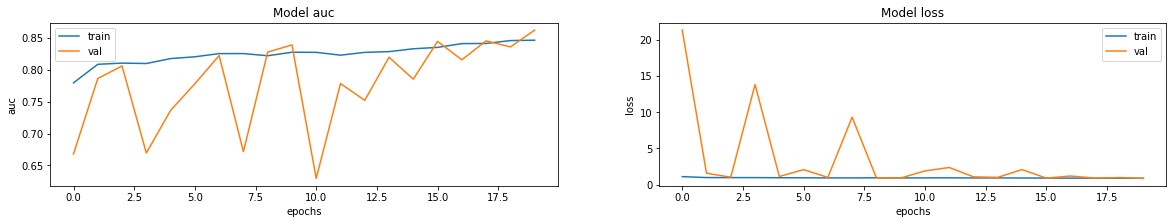

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Now we import the testing dataset.

In [ ]:
testDataLoc = "/content/sample_data/Alzheimer_s Dataset/test"

# Creating the training dataset (keeping 20% for validation)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDataLoc,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)


Found 1279 files belonging to 4 classes.


And let's evaluate our model.

In [ ]:
model.evaluate(test_ds)

80/80 [==============================] - 2s 21ms/step - loss: 0.9144 - auc: 0.8405


[0.914376974105835, 0.8404805660247803]

In [ ]:
import numpy as np
predicted_classes = model.predict(test_ds).argmax(axis=1)

80/80 [==============================] - 2s 17ms/step


In [ ]:
test_classes = np.concatenate([y for x, y in test_ds], axis=0).argmax(axis=1)

Let's check how well we did. For this we build the confusion matrix.

Note that the predictions are in the column.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

cm = np.array(confusion_matrix(test_classes, predicted_classes, labels = [0, 1, 2, 3]))

confusion = pd.DataFrame(cm, index = class_names, columns = [class_names] )

confusion

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented
MildDemented,0,0,161,18
ModerateDemented,0,0,10,2
NonDemented,2,0,570,68
VeryMildDemented,1,0,379,68


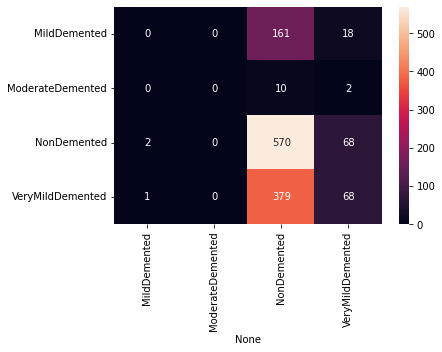

In [ ]:
import seaborn as sns
sns.heatmap(confusion, annot=True, fmt='g')

Let's try with another model.

In [ ]:
model2 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=4, activation='softmax'),
])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 109824)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 439300    
                                                                 
 dense_5 (Dense)             (None, 8)                 40        
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 439,552
Trainable params: 439,552
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'),
    loss='categorical_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

EPOCHS2=20

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS2
)

Epoch 1/20
257/257 [==============================] - 6s 21ms/step - loss: 73.8518 - auc: 0.7381 - val_loss: 1.0489 - val_auc: 0.7780 - lr: 0.0100
Epoch 2/20
257/257 [==============================] - 5s 20ms/step - loss: 1.0385 - auc: 0.7800 - val_loss: 1.0434 - val_auc: 0.7780 - lr: 0.0089
Epoch 3/20
257/257 [==============================] - 5s 19ms/step - loss: 1.0361 - auc: 0.7798 - val_loss: 1.0434 - val_auc: 0.7780 - lr: 0.0079
Epoch 4/20
257/257 [==============================] - 5s 19ms/step - loss: 1.0353 - auc: 0.7793 - val_loss: 1.0445 - val_auc: 0.7780 - lr: 0.0071
Epoch 5/20
257/257 [==============================] - 5s 20ms/step - loss: 1.0353 - auc: 0.7802 - val_loss: 1.0444 - val_auc: 0.7780 - lr: 0.0063
Epoch 6/20
257/257 [==============================] - 6s 24ms/step - loss: 1.0350 - auc: 0.7805 - val_loss: 1.0436 - val_auc: 0.7780 - lr: 0.0056
Epoch 7/20
257/257 [==============================] - 5s 20ms/step - loss: 1.0348 - auc: 0.7805 - val_loss: 1.0440 - val_au

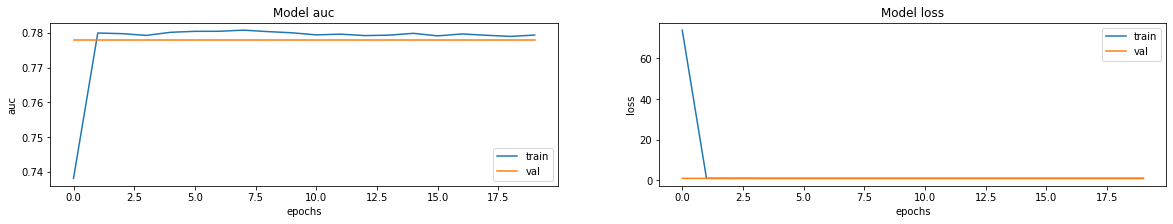

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
predicted_classes2 = model2.predict(test_ds).argmax(axis=1)

cm2 = np.array(confusion_matrix(test_classes, predicted_classes2, labels = [0, 1, 2, 3]))

confusion2 = pd.DataFrame(cm2, index = class_names, columns = [class_names] )

confusion2

80/80 [==============================] - 1s 13ms/step


,MildDemented,ModerateDemented,NonDemented,VeryMildDemented
MildDemented,0,0,179,0
ModerateDemented,0,0,12,0
NonDemented,0,0,640,0
VeryMildDemented,0,0,448,0
